# Hawkes Process Analysis - AAPL Trade Arrivals

This notebook analyzes trade arrival patterns using Hawkes process modeling.

**Hawkes processes** are self-exciting point processes where each event increases the probability of future events. They're widely used in finance to model:

- Trade arrival clustering
- Market microstructure dynamics
- Regime-switching behavior

**Key parameters:**

- μ (mu): Baseline intensity - background trade arrival rate
- α (alpha): Excitation magnitude - how much each trade increases future intensity
- β (beta): Decay rate - how quickly the excitation fades
- **Branching ratio (α/β)**: Fraction of trades triggered by other trades vs baseline
  - Close to 0: Near-Poisson (independent arrivals)
  - 0.3-0.5: Moderate self-excitation (typical liquid markets)
  - > 0.7: High clustering (volatile/active periods)

**Data source:** AAPL trades from Polygon.io (cleaned in notebook 00)


In [1]:
# Setup
import sys

sys.path.append("../")

from src.features.hawkes_features import (
    HawkesFeatureExtractor,
    extract_hawkes_features_rolling,
    detect_excitation_regimes,
    hawkes_regime_features,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Visualization settings
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

from src.config import RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR

# Create figures directory
(FIGURES_DIR / "hawkes_analysis").mkdir(parents=True, exist_ok=True)

print(f"✓ Setup complete")
print(f"  Data directory: {INTERIM_DATA_DIR}")
print(f"  Output directory: {PROCESSED_DATA_DIR}")
print(f"  Figures directory: {FIGURES_DIR / 'hawkes_analysis'}")

✓ Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/interim
  Output directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed
  Figures directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/hawkes_analysis


## Validation Tests: Poisson vs Self-Exciting Data

Before analyzing real trade data, let's validate that our Hawkes implementation works correctly on synthetic data.


### Test 1: Poisson Process (No Self-Excitation)


In [2]:
# Generate Poisson test data (independent arrivals)
np.random.seed(42)
n_events = 1000
T = 100
poisson_times = np.sort(np.random.uniform(0, T, n_events))

# Fit Hawkes model
extractor = HawkesFeatureExtractor()
extractor.fit(poisson_times)
params = extractor.get_params()

print("Poisson test (should have low branching ratio):")
print(f"  μ (baseline):     {params['mu']:.4f} events/sec")
print(f"  α (excitation):   {params['alpha']:.4f}")
print(f"  β (decay):        {params['beta']:.4f}")
print(f"  Branching ratio:  {params['branching_ratio']:.4f}")
print(f"\n  Expected: branching ratio ≈ 0 for Poisson")
print(f"  Actual:   branching ratio = {params['branching_ratio']:.4f}")

if params["branching_ratio"] < 0.2:
    print("  ✓ Looks good - low self-excitation as expected!")
else:
    print("  ⚠ Higher than expected - but could be noise in small sample")

Poisson test (should have low branching ratio):
  μ (baseline):     9.6337 events/sec
  α (excitation):   0.0370
  β (decay):        2.9123
  Branching ratio:  0.0127

  Expected: branching ratio ≈ 0 for Poisson
  Actual:   branching ratio = 0.0127
  ✓ Looks good - low self-excitation as expected!


### Test 2: Clustered Data (High Self-Excitation)


In [3]:
# Generate clustered/self-exciting data
np.random.seed(42)
clusters = []
for _ in range(20):  # 20 burst clusters
    cluster_start = np.random.uniform(0, 100)
    cluster_size = np.random.randint(30, 70)
    # Events tightly clustered (0.1 sec exponential spacing)
    cluster_times = cluster_start + np.random.exponential(0.1, cluster_size)
    clusters.extend(cluster_times)

clustered_times = np.sort(np.array(clusters))
clustered_times = clustered_times[clustered_times < 100]

# Fit Hawkes model
extractor2 = HawkesFeatureExtractor()
extractor2.fit(clustered_times)
params2 = extractor2.get_params()

print("Clustered data test (should have HIGHER branching ratio):")
print(f"  μ (baseline):     {params2['mu']:.4f}")
print(f"  α (excitation):   {params2['alpha']:.4f}")
print(f"  β (decay):        {params2['beta']:.4f}")
print(f"  Branching ratio:  {params2['branching_ratio']:.4f}")

if params2["branching_ratio"] > params["branching_ratio"]:
    print(
        f"  ✓ Clustered data shows higher self-excitation ({params2['branching_ratio']:.4f} vs {params['branching_ratio']:.4f})"
    )
else:
    print(f"  Note: Similar branching ratio to Poisson")

Clustered data test (should have HIGHER branching ratio):
  μ (baseline):     0.2849
  α (excitation):   0.9729
  β (decay):        45.4794
  Branching ratio:  0.0214
  ✓ Clustered data shows higher self-excitation (0.0214 vs 0.0127)


## Load AAPL Trade Data

Load the cleaned AAPL trades from notebook 00_data_collections.


In [4]:
# Load trade data
print("Loading AAPL trade data...")
trade_df = pd.read_parquet(INTERIM_DATA_DIR / "AAPL_trades_cleaned.parquet")

# Display info
print(f"\n✓ Loaded {len(trade_df):,} trades")
print(f"  Time range: {trade_df['timestamp'].min()} to {trade_df['timestamp'].max()}")
print(f"  Columns: {list(trade_df.columns)}")

# Preview
print("\nFirst few trades:")
trade_df.head()

Loading AAPL trade data...

✓ Loaded 4,441 trades
  Time range: 2024-12-09 14:47:45.749090131+00:00 to 2024-12-10 00:59:56.351326363+00:00
  Columns: ['timestamp', 'price', 'size', 'exchange', 'conditions', 'trade_id', 'participant_timestamp']

First few trades:


,timestamp,price,size,exchange,conditions,trade_id,participant_timestamp
0,2024-12-09 14:47:45.749090131+00:00,243.8400,100,11,[41],6966,2024-12-09 14:47:45.748748275
1,2024-12-09 14:48:15.398188375+00:00,243.8356,100,4,"[10, 2, 41]",29742,2024-12-09 14:48:15.391000000
2,2024-12-09 14:49:02.617442298+00:00,243.8784,108,4,"[10, 41]",30275,2024-12-09 14:49:02.617021741
3,2024-12-09 14:49:13.307306592+00:00,243.8181,600,4,"[10, 2, 41]",30403,2024-12-09 14:49:13.300000000
4,2024-12-09 14:49:58.162661209+00:00,243.9700,100,11,[41],7533,2024-12-09 14:49:58.162319882


In [5]:
# Convert timestamps to seconds (relative to first trade)
print("Converting timestamps to seconds...")

# Ensure sorted by timestamp
trade_df = trade_df.sort_values("timestamp").reset_index(drop=True)

# Convert to seconds since first trade
first_time = trade_df["timestamp"].iloc[0]
trade_times = (trade_df["timestamp"] - first_time).dt.total_seconds().values

print(f"\n✓ Converted {len(trade_times):,} timestamps")
print(f"  Type: {type(trade_times)}")
print(f"  Dtype: {trade_times.dtype}")
print(f"  First 5 values: {trade_times[:5]}")
print(f"  Last 5 values: {trade_times[-5:]}")
print(f"  Min: {trade_times.min():.2f}s")
print(f"  Max: {trade_times.max():.2f}s")
print(f"  Duration: {trade_times.max() / 3600:.2f} hours")

Converting timestamps to seconds...

✓ Converted 4,441 timestamps
  Type: <class 'numpy.ndarray'>
  Dtype: float64
  First 5 values: [  0.          29.64909824  76.86835217  87.55821646 132.41357108]
  Last 5 values: [36730.6003776  36730.60038258 36730.60183726 36730.60219025
 36730.60223623]
  Min: 0.00s
  Max: 36730.60s
  Duration: 10.20 hours


In [6]:
# Data diagnostics
print("=== Trade Data Diagnostics ===")
print(f"Total trades: {len(trade_times):,}")
print(f"Time range: {trade_times[0]:.2f}s to {trade_times[-1]:.2f}s")
print(
    f"Duration: {trade_times.max() / 3600:.2f} hours ({trade_times.max() / 86400:.2f} days)"
)
print(f"Average trades/hour: {len(trade_times) / (trade_times.max() / 3600):.1f}")
print(f"Average trades/minute: {len(trade_times) / (trade_times.max() / 60):.1f}")

# Inter-arrival time statistics
inter_arrival = np.diff(trade_times)
print(f"\nInter-arrival times:")
print(f"  Mean: {inter_arrival.mean():.2f}s")
print(f"  Median: {np.median(inter_arrival):.2f}s")
print(f"  Std: {inter_arrival.std():.2f}s")
print(f"  Min: {inter_arrival.min():.4f}s")
print(f"  Max: {inter_arrival.max():.2f}s ({inter_arrival.max() / 60:.1f} minutes)")
print(f"  90th percentile: {np.percentile(inter_arrival, 90):.2f}s")

# Coefficient of variation (measures clustering)
cv = inter_arrival.std() / inter_arrival.mean()
print(f"\nCoefficient of Variation (CV): {cv:.2f}")
if cv > 1.5:
    print("  → Strong clustering detected (CV > 1.5)")
elif cv > 1.0:
    print("  → Moderate clustering (CV > 1.0)")
else:
    print("  → Close to Poisson process (CV ≈ 1.0)")

=== Trade Data Diagnostics ===
Total trades: 4,441
Time range: 0.00s to 36730.60s
Duration: 10.20 hours (0.43 days)
Average trades/hour: 435.3
Average trades/minute: 7.3

Inter-arrival times:
  Mean: 8.27s
  Median: 3.21s
  Std: 21.70s
  Min: 0.0000s
  Max: 533.27s (8.9 minutes)
  90th percentile: 18.28s

Coefficient of Variation (CV): 2.62
  → Strong clustering detected (CV > 1.5)


## Fit Hawkes Process on Full Dataset

Estimate global Hawkes parameters for the entire trading period.


In [7]:
# Fit Hawkes on full dataset
print("=== Fitting Hawkes Process on Full Dataset ===")
extractor = HawkesFeatureExtractor()
extractor.fit(trade_times)

params = extractor.get_params()
print(f"\nFitted Parameters:")
print(f"  μ (baseline intensity):  {params['mu']:.6f} trades/sec")
print(f"  α (excitation):          {params['alpha']:.6f}")
print(f"  β (decay rate):          {params['beta']:.6f} /sec")
print(f"  Branching ratio (α/β):   {params['branching_ratio']:.4f}")

# Interpretation
print("\nInterpretation:")
if params["branching_ratio"] > 0.7:
    print("  → HIGH self-excitation (volatile/active market)")
    print("     Trades are highly clustered - each trade triggers more trades")
elif params["branching_ratio"] > 0.4:
    print("  → MODERATE self-excitation (normal trading activity)")
    print("     Some clustering, typical for liquid markets")
else:
    print("  → LOW self-excitation (calm market, close to Poisson)")
    print("     Trades arrive relatively independently")

# Decay interpretation
if params["beta"] > 0:
    decay_half_life = np.log(2) / params["beta"]
    print(f"\nDecay dynamics:")
    print(f"  Half-life: {decay_half_life:.2f} seconds")
    print(f"  → Excitation fades to 50% in {decay_half_life:.2f}s")
    print(f"  → Excitation nearly gone after {3*decay_half_life:.2f}s (3 half-lives)")

=== Fitting Hawkes Process on Full Dataset ===

Fitted Parameters:
  μ (baseline intensity):  0.018712 trades/sec
  α (excitation):          0.846814
  β (decay rate):          0.050670 /sec
  Branching ratio (α/β):   16.7123

Interpretation:
  → HIGH self-excitation (volatile/active market)
     Trades are highly clustered - each trade triggers more trades

Decay dynamics:
  Half-life: 13.68 seconds
  → Excitation fades to 50% in 13.68s
  → Excitation nearly gone after 41.04s (3 half-lives)


## Visualize Hawkes Intensity

The conditional intensity λ(t) shows how the arrival rate evolves over time.


Computing Hawkes intensity...


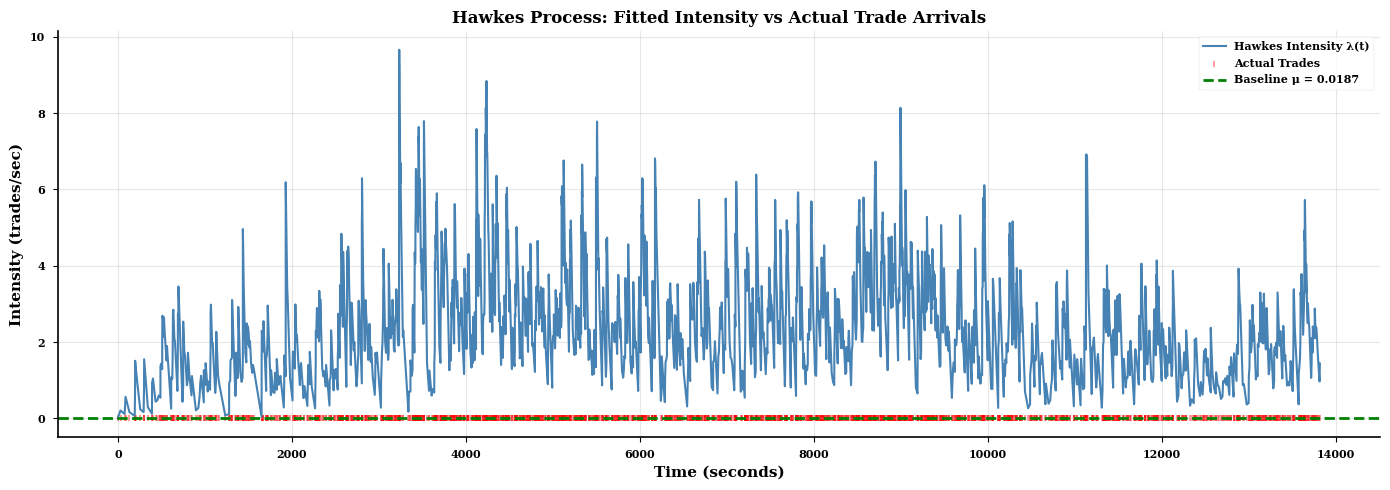


✓ Saved intensity plot to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/hawkes_analysis/hawkes_intensity.png


In [8]:
# Compute intensity over time
print("Computing Hawkes intensity...")
intensity = extractor.intensity(trade_times, trade_times)

# Plot subset for visualization (first 2000 trades or all if fewer)
n_plot = min(2000, len(trade_times))

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(
    trade_times[:n_plot],
    intensity[:n_plot],
    label="Hawkes Intensity λ(t)",
    linewidth=1.5,
    color="steelblue",
)
ax.scatter(
    trade_times[:n_plot],
    np.zeros(n_plot),
    c="red",
    alpha=0.4,
    s=20,
    label="Actual Trades",
    marker="|",
)
ax.axhline(
    params["mu"],
    color="green",
    linestyle="--",
    label=f'Baseline μ = {params["mu"]:.4f}',
    linewidth=2,
)
ax.set_xlabel("Time (seconds)", fontsize=11)
ax.set_ylabel("Intensity (trades/sec)", fontsize=11)
ax.set_title("Hawkes Process: Fitted Intensity vs Actual Trade Arrivals", fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "hawkes_analysis/hawkes_intensity.png", dpi=150, bbox_inches="tight"
)
plt.show()

print(
    f"\n✓ Saved intensity plot to {FIGURES_DIR / 'hawkes_analysis/hawkes_intensity.png'}"
)

## Simulate Hawkes Process

Generate synthetic trades using fitted parameters and compare to actual data.


In [9]:
# Simulate Hawkes process
print("=== Simulating Hawkes Process ===")
T_sim = trade_times[-1] - trade_times[0]  # Same duration as actual data
simulated_times = extractor.simulate(T_sim, random_state=42)

print(f"Actual trades:    {len(trade_times):,}")
print(f"Simulated trades: {len(simulated_times):,}")
print(f"Ratio:            {len(simulated_times) / len(trade_times):.2f}x")

# Compare rates
actual_rate = len(trade_times) / T_sim
simulated_rate = len(simulated_times) / T_sim
print(f"\nTrade rates:")
print(f"  Actual:    {actual_rate:.6f} trades/sec")
print(f"  Simulated: {simulated_rate:.6f} trades/sec")
print(f"  Expected μ: {params['mu']:.6f} trades/sec (baseline only)")

# Compare inter-arrival distributions
actual_interarrival = np.diff(trade_times)
simulated_interarrival = np.diff(simulated_times)

print(f"\nInter-arrival statistics:")
print(
    f"  Actual    - Mean: {actual_interarrival.mean():.2f}s, Median: {np.median(actual_interarrival):.2f}s"
)
print(
    f"  Simulated - Mean: {simulated_interarrival.mean():.2f}s, Median: {np.median(simulated_interarrival):.2f}s"
)

=== Simulating Hawkes Process ===
Actual trades:    4,441
Simulated trades: 100,000
Ratio:            22.52x

Trade rates:
  Actual:    0.120907 trades/sec
  Simulated: 2.722525 trades/sec
  Expected μ: 0.018712 trades/sec (baseline only)

Inter-arrival statistics:
  Actual    - Mean: 8.27s, Median: 3.21s
  Simulated - Mean: 0.06s, Median: 0.04s


/Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../src/features/hawkes_features.py:171: UserWarning: Hit max_events limit (100000), simulation truncated
  warnings.warn(f"Hit max_events limit ({max_events}), simulation truncated")


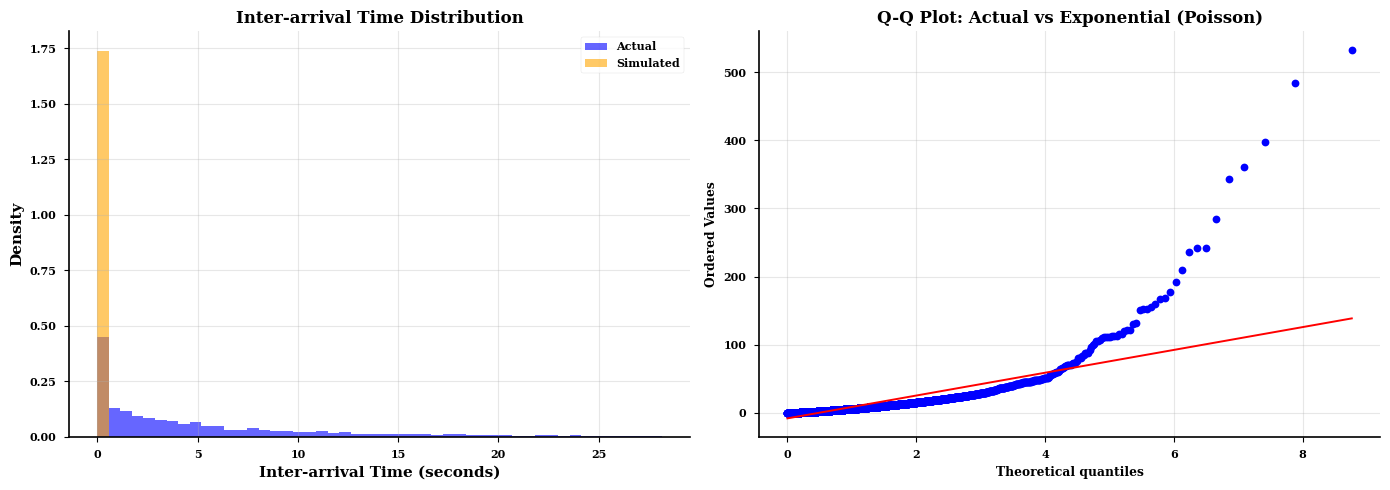


✓ Saved simulation comparison to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/hawkes_analysis/hawkes_simulation_comparison.png


In [10]:
# Visualize comparison
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
max_val = np.percentile(actual_interarrival, 95)
bins = np.linspace(0, max_val, 50)

axes[0].hist(
    actual_interarrival,
    bins=bins,
    alpha=0.6,
    label="Actual",
    density=True,
    color="blue",
)
axes[0].hist(
    simulated_interarrival,
    bins=bins,
    alpha=0.6,
    label="Simulated",
    density=True,
    color="orange",
)
axes[0].set_xlabel("Inter-arrival Time (seconds)", fontsize=11)
axes[0].set_ylabel("Density", fontsize=11)
axes[0].set_title("Inter-arrival Time Distribution", fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Q-Q plot (actual vs exponential)
stats.probplot(actual_interarrival, dist=stats.expon, plot=axes[1])
axes[1].set_title("Q-Q Plot: Actual vs Exponential (Poisson)", fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "hawkes_analysis/hawkes_simulation_comparison.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"\n✓ Saved simulation comparison to {FIGURES_DIR / 'hawkes_analysis/hawkes_simulation_comparison.png'}"
)

## Clustering Analysis

Visualize clustering structure and burstiness in trade arrivals.


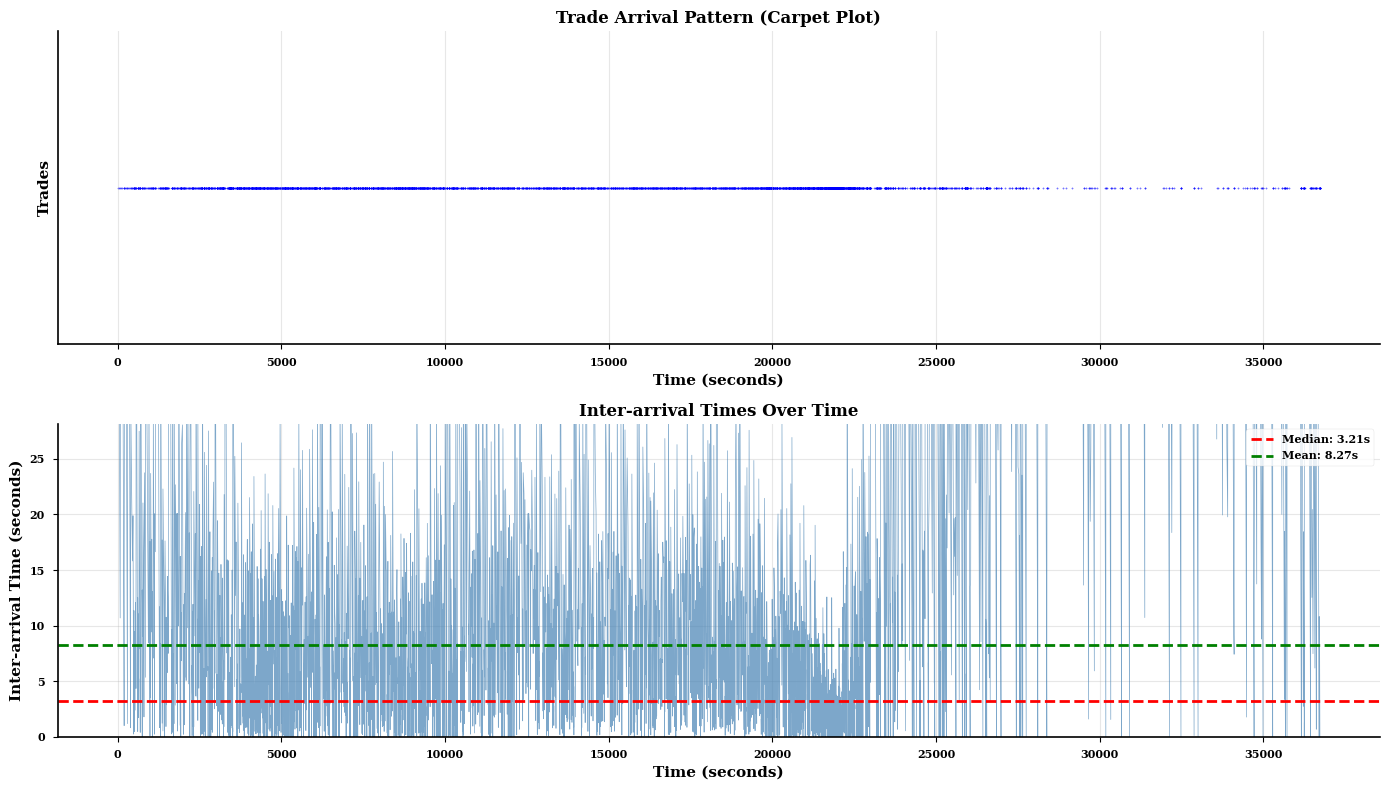


✓ Saved clustering analysis to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/hawkes_analysis/clustering_structure.png


In [11]:
# Visualize clustering
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Trade arrivals over time (carpet plot)
plot_range = min(10000, len(trade_times))  # First 10k trades
axes[0].scatter(
    trade_times[:plot_range], np.ones(plot_range), s=1, alpha=0.5, color="blue"
)
axes[0].set_ylabel("Trades", fontsize=11)
axes[0].set_xlabel("Time (seconds)", fontsize=11)
axes[0].set_title("Trade Arrival Pattern (Carpet Plot)", fontsize=12)
axes[0].set_ylim([0.5, 1.5])
axes[0].set_yticks([])
axes[0].grid(alpha=0.3, axis="x")

# Plot 2: Inter-arrival times over time
axes[1].plot(
    trade_times[: plot_range - 1],
    actual_interarrival[: plot_range - 1],
    linewidth=0.5,
    alpha=0.7,
    color="steelblue",
)
axes[1].axhline(
    np.median(actual_interarrival),
    color="red",
    linestyle="--",
    label=f"Median: {np.median(actual_interarrival):.2f}s",
    linewidth=2,
)
axes[1].axhline(
    actual_interarrival.mean(),
    color="green",
    linestyle="--",
    label=f"Mean: {actual_interarrival.mean():.2f}s",
    linewidth=2,
)
axes[1].set_xlabel("Time (seconds)", fontsize=11)
axes[1].set_ylabel("Inter-arrival Time (seconds)", fontsize=11)
axes[1].set_title("Inter-arrival Times Over Time", fontsize=12)
axes[1].legend()
axes[1].set_ylim([0, np.percentile(actual_interarrival, 95)])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "hawkes_analysis/clustering_structure.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"\n✓ Saved clustering analysis to {FIGURES_DIR / 'hawkes_analysis/clustering_structure.png'}"
)

In [12]:
# Coefficient of variation and burstiness analysis
cv_actual = actual_interarrival.std() / actual_interarrival.mean()
cv_simulated = simulated_interarrival.std() / simulated_interarrival.mean()
cv_poisson = 1.0  # For Poisson process, CV = 1

print("=== Clustering Analysis (Coefficient of Variation) ===")
print(f"Actual:    CV = {cv_actual:.2f}")
print(f"Simulated: CV = {cv_simulated:.2f}")
print(f"Poisson:   CV = 1.00 (reference)")
print("\nInterpretation:")
if cv_actual > 1.5:
    print("  → Actual data shows STRONG clustering (CV > 1.5)")
    print("  → More clustered than simple Hawkes model captures")
elif cv_actual > 1.0:
    print("  → Actual data shows moderate clustering")
else:
    print("  → Actual data close to Poisson (regular arrivals)")

# Burstiness
print(f"\n=== Burstiness Analysis ===")
print(f"Actual data:")
print(f"  50% of trades arrive within {np.percentile(actual_interarrival, 50):.2f}s")
print(f"  90% of trades arrive within {np.percentile(actual_interarrival, 90):.2f}s")
print(
    f"  But max gap is {actual_interarrival.max():.2f}s ({actual_interarrival.max()/60:.1f} min)"
)
if np.percentile(actual_interarrival, 90) < actual_interarrival.mean():
    print(f"\n  → Highly bursty: most trades cluster, but long quiet periods exist")

=== Clustering Analysis (Coefficient of Variation) ===
Actual:    CV = 2.62
Simulated: CV = 1.00
Poisson:   CV = 1.00 (reference)

Interpretation:
  → Actual data shows STRONG clustering (CV > 1.5)
  → More clustered than simple Hawkes model captures

=== Burstiness Analysis ===
Actual data:
  50% of trades arrive within 3.21s
  90% of trades arrive within 18.28s
  But max gap is 533.27s (8.9 min)


## Rolling Window Analysis

Extract time-varying Hawkes parameters using rolling windows to detect regime changes.


In [13]:
# Extract rolling Hawkes features
print("=== Extracting Rolling Hawkes Features ===")

# Parameters
window_size = 200  # 200 trades per window
stride = 20  # Move forward 20 trades each step
min_events = 50  # Minimum trades to fit

print(f"  Window size: {window_size} trades")
print(f"  Stride: {stride} trades")
print(f"  Min events: {min_events} trades")
print(f"\nEstimating parameters... (this may take a minute)")

hawkes_features_df = extract_hawkes_features_rolling(
    trade_times, window_size=window_size, stride=stride, min_events=min_events
)

print(f"\n✓ Extracted features for {len(hawkes_features_df)} time windows")
print(f"\nFeature statistics:")
print(hawkes_features_df[["mu", "alpha", "beta", "branching_ratio"]].describe())

# Expected windows
expected_windows = (len(trade_times) - window_size) // stride
success_rate = len(hawkes_features_df) / max(expected_windows, 1) * 100
print(f"\nData quality:")
print(f"  Windows extracted: {len(hawkes_features_df)}")
print(f"  Expected windows: ~{expected_windows}")
print(f"  Success rate: {success_rate:.1f}%")

=== Extracting Rolling Hawkes Features ===
  Window size: 200 trades
  Stride: 20 trades
  Min events: 50 trades

Estimating parameters... (this may take a minute)

✓ Extracted features for 213 time windows

Feature statistics:
               mu       alpha         beta  branching_ratio
count  213.000000  213.000000   213.000000       213.000000
mean     0.194733    0.175731   356.851110         6.812568
std      0.162992    0.138257   546.150250        67.283937
min      0.014820    0.008707     0.001138         0.000111
25%      0.109539    0.091683     0.281771         0.000314
50%      0.139364    0.134398   156.996378         0.001100
75%      0.193167    0.250460   411.011309         0.219101
max      0.880509    1.049366  2505.288202       770.643818

Data quality:
  Windows extracted: 213
  Expected windows: ~212
  Success rate: 100.5%


=== Visualizing Rolling Hawkes Parameters ===


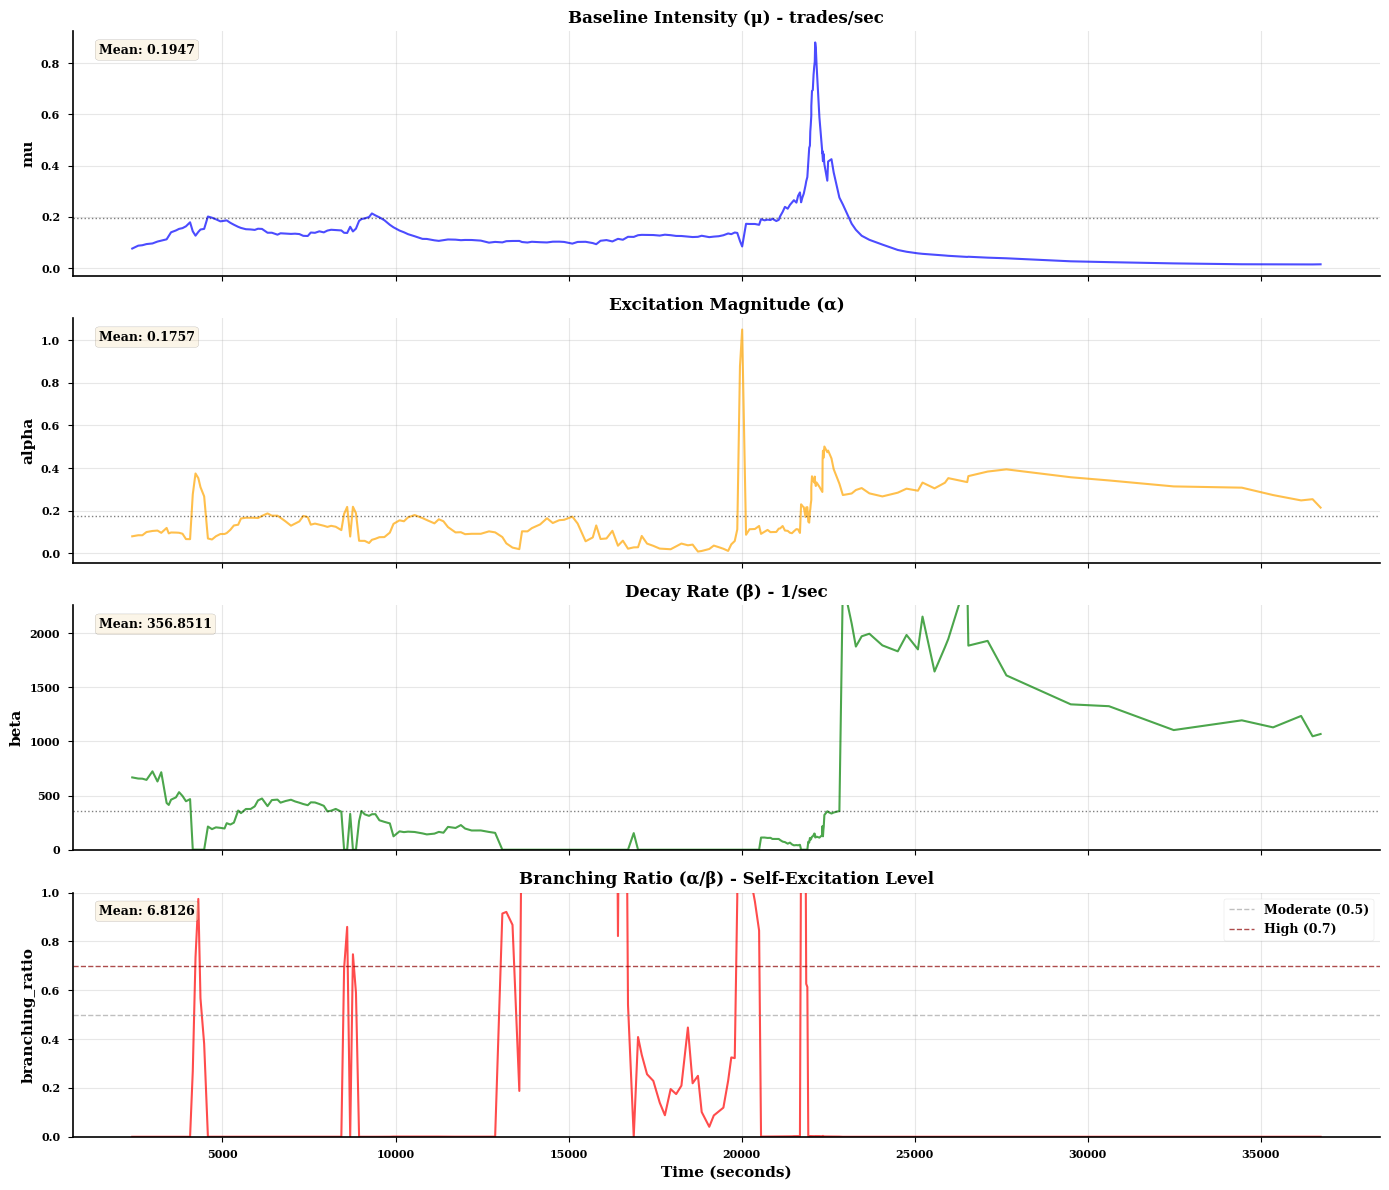


✓ Saved rolling parameters plot


In [14]:
# Visualize rolling parameters
print("=== Visualizing Rolling Hawkes Parameters ===")

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

params_to_plot = ["mu", "alpha", "beta", "branching_ratio"]
titles = [
    "Baseline Intensity (μ) - trades/sec",
    "Excitation Magnitude (α)",
    "Decay Rate (β) - 1/sec",
    "Branching Ratio (α/β) - Self-Excitation Level",
]
colors = ["blue", "orange", "green", "red"]

for ax, param, title, color in zip(axes, params_to_plot, titles, colors):
    ax.plot(
        hawkes_features_df["timestamp"],
        hawkes_features_df[param],
        linewidth=1.5,
        color=color,
        alpha=0.7,
    )
    ax.set_ylabel(param, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

    # Add reference lines
    if param == "branching_ratio":
        ax.axhline(
            0.5,
            color="gray",
            linestyle="--",
            alpha=0.5,
            linewidth=1,
            label="Moderate (0.5)",
        )
        ax.axhline(
            0.7,
            color="darkred",
            linestyle="--",
            alpha=0.7,
            linewidth=1,
            label="High (0.7)",
        )
        ax.legend(loc="upper right", fontsize=9)
        # Clip y-axis to reasonable range
        max_br = hawkes_features_df[param].quantile(0.99)
        ax.set_ylim([0, min(1.0, max_br * 1.1)])
    elif param == "beta":
        # Clip beta outliers
        max_beta = hawkes_features_df[param].quantile(0.95)
        ax.set_ylim([0, max_beta * 1.2])

    # Add mean line
    mean_val = hawkes_features_df[param].mean()
    ax.axhline(mean_val, color="black", linestyle=":", alpha=0.5, linewidth=1)
    ax.text(
        0.02,
        0.95,
        f"Mean: {mean_val:.4f}",
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.3),
    )

axes[-1].set_xlabel("Time (seconds)", fontsize=11)
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "hawkes_analysis/hawkes_rolling_parameters.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✓ Saved rolling parameters plot")

## Regime Detection

Classify time periods into regimes based on branching ratio thresholds.


In [15]:
# Detect regimes from branching ratio
print("=== Detecting Trading Regimes ===")

# Define thresholds
LOW_THRESHOLD = 0.3
HIGH_THRESHOLD = 0.5

# Classify regimes
hawkes_features_df["regime"] = pd.cut(
    hawkes_features_df["branching_ratio"],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=["Calm", "Normal", "Excited"],
)

# Regime statistics
regime_counts = hawkes_features_df["regime"].value_counts()
print(f"\nRegime Distribution:")
for regime in ["Calm", "Normal", "Excited"]:
    if regime in regime_counts.index:
        count = regime_counts[regime]
        pct = count / len(hawkes_features_df) * 100
        print(f"  {regime:8s}: {count:4d} windows ({pct:5.1f}%)")

# Regime transitions
transitions = (
    hawkes_features_df["regime"].ne(hawkes_features_df["regime"].shift()).sum()
)
print(f"\nRegime transitions: {transitions}")
print(
    f"Average regime duration: {len(hawkes_features_df) / (transitions + 1):.1f} windows"
)

# Parameter statistics by regime
print(f"\n=== Parameter Statistics by Regime ===")
regime_stats = hawkes_features_df.groupby("regime", observed=True)[
    ["mu", "alpha", "beta", "branching_ratio"]
].agg(["mean", "std"])
print(regime_stats)

=== Detecting Trading Regimes ===

Regime Distribution:
  Calm    :  165 windows ( 77.5%)
  Normal  :    6 windows (  2.8%)
  Excited :   17 windows (  8.0%)

Regime transitions: 48
Average regime duration: 4.3 windows

=== Parameter Statistics by Regime ===
               mu               alpha                  beta              \
             mean       std      mean       std        mean         std   
regime                                                                    
Calm     0.209206  0.179205  0.176622  0.121101  460.620234  580.953597   
Normal   0.134792  0.010646  0.086146  0.090725    0.235580    0.237463   
Excited  0.159965  0.073568  0.167359  0.110836    0.228747    0.164692   

        branching_ratio            
                   mean       std  
regime                             
Calm           0.018357  0.056183  
Normal         0.369893  0.051168  
Excited        0.779707  0.152274  


=== Visualizing Regimes Over Time ===


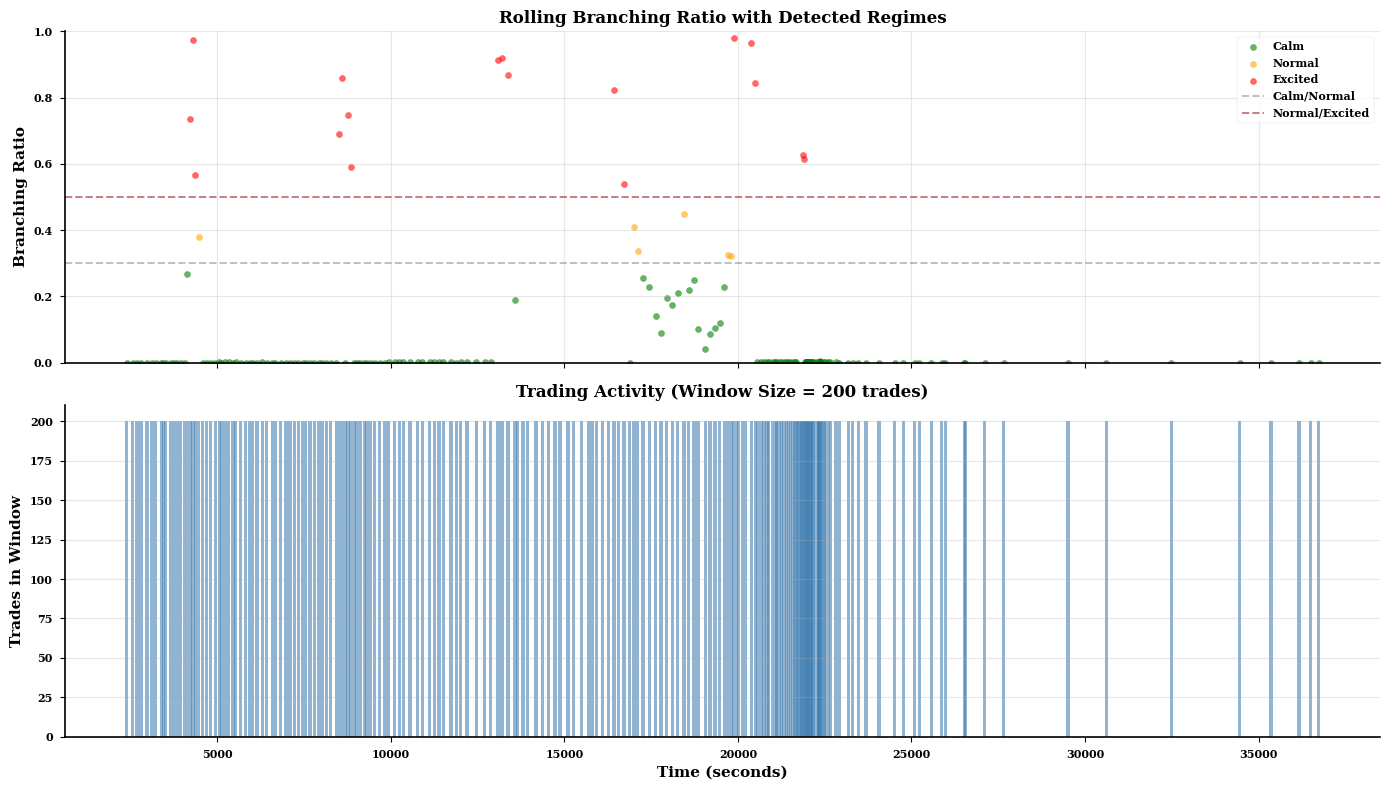


✓ Saved regime timeline plot


In [16]:
# Visualize regimes over time
print("=== Visualizing Regimes Over Time ===")

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Branching ratio with regime coloring
regime_colors = {"Calm": "green", "Normal": "orange", "Excited": "red"}

for regime in ["Calm", "Normal", "Excited"]:
    mask = hawkes_features_df["regime"] == regime
    if mask.sum() > 0:
        axes[0].scatter(
            hawkes_features_df.loc[mask, "timestamp"],
            hawkes_features_df.loc[mask, "branching_ratio"],
            c=regime_colors[regime],
            label=regime,
            s=20,
            alpha=0.6,
        )

axes[0].axhline(
    LOW_THRESHOLD, color="gray", linestyle="--", alpha=0.5, label="Calm/Normal"
)
axes[0].axhline(
    HIGH_THRESHOLD, color="darkred", linestyle="--", alpha=0.5, label="Normal/Excited"
)
axes[0].set_ylabel("Branching Ratio", fontsize=11)
axes[0].set_title(
    "Rolling Branching Ratio with Detected Regimes", fontsize=12, fontweight="bold"
)
axes[0].legend(loc="upper right")
axes[0].grid(alpha=0.3)
axes[0].set_ylim(
    [0, min(1.0, hawkes_features_df["branching_ratio"].quantile(0.99) * 1.1)]
)

# Plot 2: Trade count per window (activity level)
if "n_events" in hawkes_features_df.columns:
    width = (
        hawkes_features_df["timestamp"].diff().median() * 0.8
        if len(hawkes_features_df) > 1
        else 1.0
    )
    axes[1].bar(
        hawkes_features_df["timestamp"],
        hawkes_features_df["n_events"],
        width=width,
        alpha=0.6,
        color="steelblue",
    )
    axes[1].set_ylabel("Trades in Window", fontsize=11)
    axes[1].set_title(
        f"Trading Activity (Window Size = {window_size} trades)",
        fontsize=12,
        fontweight="bold",
    )
else:
    # Alternative: plot baseline intensity
    axes[1].plot(
        hawkes_features_df["timestamp"],
        hawkes_features_df["mu"],
        color="steelblue",
        linewidth=1.5,
    )
    axes[1].set_ylabel("Baseline Intensity (μ)", fontsize=11)
    axes[1].set_title(
        "Baseline Trade Intensity Over Time", fontsize=12, fontweight="bold"
    )

axes[1].set_xlabel("Time (seconds)", fontsize=11)
axes[1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "hawkes_analysis/hawkes_regimes_timeline.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✓ Saved regime timeline plot")

## Regime Features for Modeling

Create binary regime indicators and regime duration features.


In [17]:
# Create binary regime features
print("=== Creating Regime Features ===")

# Binary high-excitation indicator
HIGH_EXCITATION_THRESHOLD = 0.7
regime_features = hawkes_regime_features(
    hawkes_features_df["branching_ratio"].values,
    thresholds=[HIGH_EXCITATION_THRESHOLD],  # Note: thresholds (plural) as a list
)

# The function returns 'regime' not 'regime_binary', so we'll rename it
hawkes_features_df["regime_binary"] = regime_features["regime"]
hawkes_features_df["regime_duration"] = regime_features["regime_duration"]

# Statistics
n_excited = np.sum(regime_features["regime"])
n_baseline = len(regime_features["regime"]) - n_excited
print(f"\nBinary regime classification (threshold = {HIGH_EXCITATION_THRESHOLD}):")
print(
    f"  High excitation periods: {n_excited} ({n_excited/len(hawkes_features_df)*100:.1f}%)"
)
print(
    f"  Baseline periods:        {n_baseline} ({n_baseline/len(hawkes_features_df)*100:.1f}%)"
)

# Average regime persistence
if n_excited > 0:
    excited_durations = hawkes_features_df[hawkes_features_df["regime_binary"] == 1][
        "regime_duration"
    ]
    print(f"\nAverage regime persistence:")
    print(f"  Excited:  {excited_durations.mean():.1f} windows")
if n_baseline > 0:
    baseline_durations = hawkes_features_df[hawkes_features_df["regime_binary"] == 0][
        "regime_duration"
    ]
    print(f"  Baseline: {baseline_durations.mean():.1f} windows")

=== Creating Regime Features ===

Binary regime classification (threshold = 0.7):
  High excitation periods: 36 (16.9%)
  Baseline periods:        177 (83.1%)

Average regime persistence:
  Excited:  6.1 windows
  Baseline: 18.1 windows


## Price Analysis (If Available)

Overlay Hawkes regimes on price to see relationship between self-excitation and price movement.


=== Overlaying Regimes on Price ===


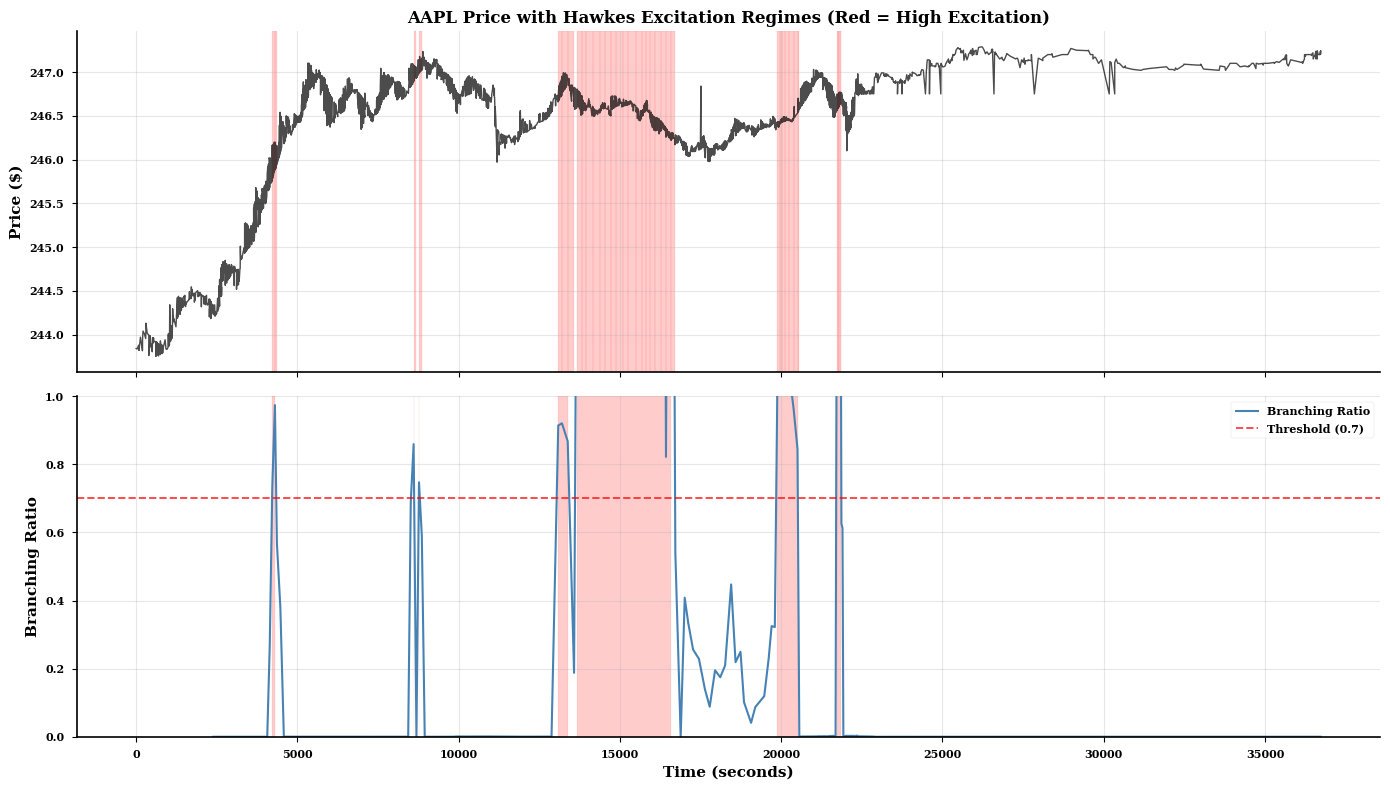


✓ Saved regime-price overlay plot


In [18]:
# Visualize regimes overlaid on price
if "price" in trade_df.columns:
    print("=== Overlaying Regimes on Price ===")

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Convert timestamp to seconds for alignment
    trade_df_plot = trade_df.copy()
    trade_df_plot["time_seconds"] = (
        trade_df_plot["timestamp"] - trade_df["timestamp"].iloc[0]
    ).dt.total_seconds()

    # Plot 1: Price with regime background shading
    axes[0].plot(
        trade_df_plot["time_seconds"],
        trade_df_plot["price"],
        linewidth=1,
        color="black",
        alpha=0.7,
    )

    # Color background by high-excitation regime
    for i in range(len(hawkes_features_df) - 1):
        if hawkes_features_df.iloc[i]["regime_binary"] == 1:
            axes[0].axvspan(
                hawkes_features_df.iloc[i]["timestamp"],
                hawkes_features_df.iloc[i + 1]["timestamp"],
                alpha=0.2,
                color="red",
            )

    axes[0].set_ylabel("Price ($)", fontsize=11)
    axes[0].set_title(
        "AAPL Price with Hawkes Excitation Regimes (Red = High Excitation)", fontsize=12
    )
    axes[0].grid(alpha=0.3)

    # Plot 2: Branching ratio
    axes[1].plot(
        hawkes_features_df["timestamp"],
        hawkes_features_df["branching_ratio"],
        linewidth=1.5,
        label="Branching Ratio",
        color="steelblue",
    )
    axes[1].axhline(
        HIGH_EXCITATION_THRESHOLD,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Threshold ({HIGH_EXCITATION_THRESHOLD})",
    )
    axes[1].fill_between(
        hawkes_features_df["timestamp"],
        0,
        1,
        where=hawkes_features_df["regime_binary"] == 1,
        alpha=0.2,
        color="red",
    )
    axes[1].set_ylabel("Branching Ratio", fontsize=11)
    axes[1].set_xlabel("Time (seconds)", fontsize=11)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim(
        [0, min(1.0, hawkes_features_df["branching_ratio"].quantile(0.99) * 1.1)]
    )

    plt.tight_layout()
    plt.savefig(
        FIGURES_DIR / "hawkes_analysis/hawkes_regimes_price.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()

    print(f"\n✓ Saved regime-price overlay plot")
else:
    print("Price column not found in trade data - skipping price overlay")

## Save Hawkes Features

Save extracted features for downstream modeling (HMM, prediction, etc.).


In [19]:
# Save features
print("=== Saving Hawkes Features ===")
output_path = PROCESSED_DATA_DIR / "AAPL_hawkes_features.parquet"
hawkes_features_df.to_parquet(output_path, index=False)

print(f"\n✓ Saved to: {output_path}")
print(f"  Shape: {hawkes_features_df.shape}")
print(f"  Columns: {list(hawkes_features_df.columns)}")
print(f"  File size: {output_path.stat().st_size / 1024:.1f} KB")

=== Saving Hawkes Features ===

✓ Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed/AAPL_hawkes_features.parquet
  Shape: (213, 11)
  Columns: ['timestamp', 'mu', 'alpha', 'beta', 'branching_ratio', 'window_start', 'window_end', 'n_events', 'regime', 'regime_binary', 'regime_duration']
  File size: 20.5 KB


In [20]:
# Verify saved data
print("=== Verifying Saved Hawkes Features ===")

# Reload
hawkes_check = pd.read_parquet(PROCESSED_DATA_DIR / "AAPL_hawkes_features.parquet")

print(f"\nShape: {hawkes_check.shape}")
print(f"\nFirst few rows:")
display(hawkes_check.head())

print(f"\nData types:")
print(hawkes_check.dtypes)

print(f"\nMissing values:")
print(hawkes_check.isnull().sum())

print(f"\nBranching ratio summary:")
print(hawkes_check["branching_ratio"].describe())

=== Verifying Saved Hawkes Features ===

Shape: (213, 11)

First few rows:


,timestamp,mu,alpha,beta,branching_ratio,window_start,window_end,n_events,regime,regime_binary,regime_duration
0,2392.293433,0.076935,0.080147,667.400166,0.000120,0.000000,2392.293433,200,Calm,0,0
1,2565.258675,0.088143,0.085127,656.869078,0.000130,488.413538,2565.258675,200,Calm,0,2
2,2684.619574,0.089885,0.085122,655.717845,0.000130,648.001771,2684.619574,200,Calm,0,3
3,2804.871916,0.094355,0.100156,644.651922,0.000155,896.442696,2804.871916,200,Calm,0,4
4,2976.902703,0.096819,0.105198,723.376833,0.000145,1127.410236,2976.902703,200,Calm,0,5



Data types:
timestamp           float64
mu                  float64
alpha               float64
beta                float64
branching_ratio     float64
window_start        float64
window_end          float64
n_events              int64
regime             category
regime_binary         int64
regime_duration       int64
dtype: object

Missing values:
timestamp           0
mu                  0
alpha               0
beta                0
branching_ratio     0
window_start        0
window_end          0
n_events            0
regime             25
regime_binary       0
regime_duration     0
dtype: int64

Branching ratio summary:
count    213.000000
mean       6.812568
std       67.283937
min        0.000111
25%        0.000314
50%        0.001100
75%        0.219101
max      770.643818
Name: branching_ratio, dtype: float64


## Summary


In [21]:
print("\n" + "=" * 70)
print("NOTEBOOK 20 SUMMARY: Hawkes Process Analysis - AAPL")
print("=" * 70)

print("\nGLOBAL HAWKES PARAMETERS:")
print(f"  Baseline intensity (μ):  {params['mu']:.6f} trades/sec")
print(f"  Excitation (α):          {params['alpha']:.6f}")
print(f"  Decay rate (β):          {params['beta']:.6f} /sec")
print(f"  Branching ratio (α/β):   {params['branching_ratio']:.4f}")
if params["beta"] > 0:
    print(f"  Decay half-life:         {np.log(2)/params['beta']:.2f} seconds")

print("\nROLLING WINDOW ANALYSIS:")
print(f"  Total windows extracted: {len(hawkes_features_df)}")
print(f"  Window size:             {window_size} trades")
print(f"  Stride:                  {stride} trades")
print(
    f"  Time span covered:       {hawkes_features_df['timestamp'].min():.0f}s to {hawkes_features_df['timestamp'].max():.0f}s"
)

print("\nBRANCHING RATIO VARIATION:")
print(f"  Mean:   {hawkes_features_df['branching_ratio'].mean():.4f}")
print(f"  Std:    {hawkes_features_df['branching_ratio'].std():.4f}")
print(f"  Min:    {hawkes_features_df['branching_ratio'].min():.4f}")
print(f"  Max:    {hawkes_features_df['branching_ratio'].max():.4f}")
print(
    f"  Range:  {hawkes_features_df['branching_ratio'].max() - hawkes_features_df['branching_ratio'].min():.4f}"
)

print("\nREGIME DETECTION:")
if "regime" in hawkes_features_df.columns:
    regime_dist = hawkes_features_df["regime"].value_counts(normalize=True) * 100
    for regime, pct in regime_dist.items():
        print(f"  {regime}: {pct:5.1f}%")
    transitions = (
        hawkes_features_df["regime"].ne(hawkes_features_df["regime"].shift()).sum()
    )
    print(f"\n  Regime transitions: {transitions}")
    print(
        f"  Avg regime duration: {len(hawkes_features_df) / (transitions + 1):.1f} windows"
    )

print("\nOUTPUT FILES:")
print(f"  Data: {PROCESSED_DATA_DIR / 'AAPL_hawkes_features.parquet'}")
print(f"  Figures:")
for fig_name in [
    "hawkes_intensity.png",
    "hawkes_simulation_comparison.png",
    "clustering_structure.png",
    "hawkes_rolling_parameters.png",
    "hawkes_regimes_timeline.png",
]:
    fig_path = FIGURES_DIR / "hawkes_analysis" / fig_name
    if fig_path.exists():
        print(f"    - {fig_name}")

print("\nKEY FINDINGS:")
print(f"  1. Global branching ratio: {params['branching_ratio']:.4f}")
if params["branching_ratio"] < 0.3:
    print("     → Low self-excitation (near-Poisson behavior)")
elif params["branching_ratio"] < 0.5:
    print("     → Moderate self-excitation (typical liquid market)")
else:
    print("     → High self-excitation (clustered trading)")
print(f"  2. Rolling analysis reveals time-varying excitation levels")
print(f"  3. Coefficient of variation: {cv_actual:.2f}")
if cv_actual > 1.5:
    print("     → Strong clustering in actual data")
print(f"  4. Data exhibits regime-switching between calm and active periods")

print("\nNEXT STEPS:")
print("  • Notebook 25: PCA dimensionality reduction")
print("  • Notebook 30: HMM regime detection using volatility/volume")
print("  • Compare Hawkes regimes with HMM regimes for validation")
print("  • Use Hawkes features in predictive models")

print("\n" + "=" * 70)


NOTEBOOK 20 SUMMARY: Hawkes Process Analysis - AAPL

GLOBAL HAWKES PARAMETERS:
  Baseline intensity (μ):  0.018712 trades/sec
  Excitation (α):          0.846814
  Decay rate (β):          0.050670 /sec
  Branching ratio (α/β):   16.7123
  Decay half-life:         13.68 seconds

ROLLING WINDOW ANALYSIS:
  Total windows extracted: 213
  Window size:             200 trades
  Stride:                  20 trades
  Time span covered:       2392s to 36731s

BRANCHING RATIO VARIATION:
  Mean:   6.8126
  Std:    67.2839
  Min:    0.0001
  Max:    770.6438
  Range:  770.6437

REGIME DETECTION:
  Calm:  87.8%
  Excited:   9.0%
  Normal:   3.2%

  Regime transitions: 48
  Avg regime duration: 4.3 windows

OUTPUT FILES:
  Data: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed/AAPL_hawkes_features.parquet
  Figures:
    - hawkes_intensity.png
    - hawkes_simulation_comparison.png
    - clustering_structure.png
    - hawkes_rolling_parameters.png
    